# **프로젝트 : 모든 장르 간 편향성 측정해 보기**
데이터를 기반으로 하는 인공지능에 대해 생각해 봅시다. 만약 우리가 가진 데이터가 이미 편향되어 있다면 이를 이용하여 만든 알고리즘 또한 편향될 확률이 매우 높습니다.

왜 데이터에 편향성이 생길까요? 언어의 사용패턴이 담긴 코퍼스야말로 인간 무의식 속에 감추어진 편향성이 고스란히 드러나는 데이터셋이기 때문입니다.

그래서 오늘은 워드 임베딩에 숨어 있는 편향성을 측정하는 대표적인 방법론인 **Word Embedding Association Test (WEAT)** 라는 기법을를 활용해 우리가 학습시킨 Word2Vec 임베딩 내의 편향성을 측정해봅시다.
# **Step1. Import necessary libraries**

In [ ]:
!pip install konlpy

In [ ]:
!pip install gensim==4.1.2

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import konlpy
from konlpy.tag import Okt
import gensim
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer

# **Step2. Extracting the word if a word class is a noun, using a morpheme analyzer**

해당 데이터는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 corpus입니다. 어떤 내용이 있는지 일부만 읽어보겠습니다. 

In [8]:
with open('/content/drive/MyDrive/GoingDeeper_Data/GD3/synopsis/synopsis.txt', 'r') as file:
    for i in range(10):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.


이제 synopsis.txt파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장해봅시다. 
이때 토큰화는 konlpy패키지의 Okt()토크나이저를 이용합니다.

In [9]:
okt = Okt()
tokenized = []
with open('/content/drive/MyDrive/GoingDeeper_Data/GD3/synopsis/synopsis.txt', 'r') as file:
    while True:
        line = file.readline() # 문자열(str)을 line변수에 저장
        if not line: break # line변수가 공백일때 반복문 멈춤
        words = okt.pos(line, stem=True, norm=True) # 토큰들의 품사를 저장 ex)('사운드', 'Noun')
        res = []
        for w in words:
            if w[1] in ['Noun']:
                res.append(w[0])
        tokenized.append(res)
        

In [10]:
# tokenized길이 확인
print(len(tokenized))

71156


In [11]:
# 내용 확인
tokenized[:5]

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤']]

# **Step3. Making embedding model with the extracted results**
시놉시스에서 추출한 명사데이터를 가지고 나만의 Word2Vec를 생성해봅니다.

In [12]:
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

모델이 잘 훈련되었는지 확인해 봅시다.

In [13]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8680614829063416),
 ('다큐멘터리', 0.8446343541145325),
 ('드라마', 0.8269726037979126),
 ('영화로', 0.7977622747421265),
 ('형식', 0.7755957245826721),
 ('코미디', 0.7710170745849609),
 ('버자이너', 0.7639609575271606),
 ('개연', 0.7622777223587036),
 ('감동', 0.7597182393074036),
 ('실화', 0.7593390345573425)]

In [14]:
model.wv.most_similar(positive=['사랑'])

[('만인', 0.740867018699646),
 ('진심', 0.7239017486572266),
 ('행복', 0.7217317819595337),
 ('만남', 0.7036583423614502),
 ('첫사랑', 0.7035991549491882),
 ('연애', 0.689065158367157),
 ('이별', 0.6820228099822998),
 ('애정', 0.6815332174301147),
 ('우정', 0.6805922985076904),
 ('고백', 0.6738978624343872)]

In [15]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.9072741270065308),
 ('영화감독', 0.8947787880897522),
 ('배우', 0.8769304752349854),
 ('각색', 0.8686336278915405),
 ('데뷔', 0.8672778606414795),
 ('대본', 0.8664335608482361),
 ('상대역', 0.8606336712837219),
 ('공연', 0.8603455424308777),
 ('영감', 0.8599784970283508),
 ('캐스팅', 0.8587828874588013)]

# **Step4. Making target wordset and attribute wordset**
WEAT score를 구할 때 단어 셋을 만들어주어야 합니다. 두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야하죠.

여기서는 두 축은 영화 구분정보를, 항목은 영화 장르를 이용하겠습니다.
- 영화구분 : 예술영화, 일반영화(상업영화)
- 영화장르 : SF, 가족, 공연, 공표, 기타, 다큐멘터리, 드라마, 멜로로맨스, 뮤지컬, 미스터리, 범죄, 사극, 서부극, 성인물, 스릴러, 애니메이션, 액션, 어드벤처, 전쟁, 코미디, 판타지

예술영화와 일반영화를 target으로 삼고, 영화장르들을 attribute로 삼아 WEAT score를 계산해보겠습니다.

# **Target Wordset**

먼저 synopsis_art.txt,synopsis_gen.txt 두 파일을 읽고, 마찬가지로 명사만 추출한다음 art, get 변수에 할당하겠습니다.

In [18]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open('/content/drive/MyDrive/GoingDeeper_Data/GD3/synopsis/'+file_name, 'r') as fread:
        print("It's reading {} file".format(file_name))
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0]))
    return ' '.join(result)

In [19]:
art = read_token(art_txt)
gen = read_token(gen_txt)

It's reading synopsis_art.txt file
It's reading synopsis_gen.txt file


In [23]:
art[:20]

'사운드 엔지니어 상우 유지태 분 치매'

In [24]:
gen[:20]

'유사 연령 성별 빈부 차이 정치 입장'

WEAT 계산을 위해서는 총 4개의 단어 셋 X, Y, A, B가 필요합니다. 예를 들면 예술영화를 가장 잘 대표하는 단어들을 art라는 단어 리스트에서부터 골라내야 합니다.

어떤 개념을 나타내는 단어를 선정하는 방법으로 어떤 것이 적당할까요? 꼭 정해진 방법이 있는 것은 아닙니다만, 예술영화를 잘 대표하는 단어란 예술영화 시놉시스에는 자주 나타나지만 다른 영화시놉시스에는 자주 나타나지 않는 것을 고르는 것이 적당할 것입니다.

이런 것과 비슷한 개념의 단어 분석 방식 중, **TF-IDF**가 있습니다. 즉, 코퍼스에서 자주 나타나는(TF가 높은) 단어이지만, 다른 코퍼스에까지 두루 걸쳐 나오지는 않는(IDF가 높은) 단어를 선정하고 싶은 것입니다. 이번에는 단어 셋 구성을 위해 TF-IDF방식을 사용하겠습니다.

In [25]:
# TF-IDF행렬(X) 생성
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])
print(X.shape)

(2, 41082)


In [51]:
vectorizer.vocabulary_['영화']

23976

In [41]:
vectorizer.get_feature_names()[23976]

'영화'

이렇게 얻은 TF-IDF행렬을가지고, TF-IDF가 높은 단어들 순으로 뽑아봅시다.

In [46]:
m1 = X[0].tocoo() # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다.
m2 = X[1].tocoo() # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다.

w1 = [[i, j] for i, j in zip(m1.col, m1.data)] # col : feature, data : tf-idf score
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True) # art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.
w2.sort(key=lambda x: x[1], reverse=True) # gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.

In [48]:
w1[:3] # tf-idf score 상위 3개의 단어 출력

[[3181, 0.3041128528402531],
 [28249, 0.29468299693822975],
 [20429, 0.29141881604906783]]

In [52]:
print("예술영화를 대표하는 단어들:")
for i in range(30):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')

print('일반영화를 대표하는 단어들:')
for i in range(30):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 

두 개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출하고 싶었는데, 양쪽에 중복된 단어가 너무 많은 것을 볼 수 있습니다. 때문에 단어가 서로 중복되지 않게 단어셋을 추출해야 합니다. 우선 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 15개의 단어를 추출해봅시다.


In [92]:
n = 15
w1_, w2_ = [], []
# 상위 100개의 feature에 mapping되있는 텍스트를 리스트에 담아줌
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고, w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

추출된 단어를 살펴봅시다.

In [95]:
target_art

['아빠',
 '음악',
 '결심',
 '운명',
 '지금',
 '여인',
 '이름',
 '이후',
 '준비',
 '감정',
 '만난',
 '처음',
 '충격',
 '누구',
 '그린']

In [96]:
target_gen

['서울',
 '애니메이션',
 '여성',
 '가지',
 '주인공',
 '대해',
 '연출',
 '사회',
 '다큐멘터리',
 '부문',
 '섹스',
 '바로',
 '의도',
 '계획',
 '정체']

## **Attribute Wordset**
이번에는 장르별 대표단어를 추출해 봅시다. 

In [183]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [100]:
# 명사만 추출해서 리스트에 저장
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

It's reading synopsis_SF.txt file
It's reading synopsis_family.txt file
It's reading synopsis_show.txt file
It's reading synopsis_horror.txt file
It's reading synopsis_etc.txt file
It's reading synopsis_documentary.txt file
It's reading synopsis_drama.txt file
It's reading synopsis_romance.txt file
It's reading synopsis_musical.txt file
It's reading synopsis_mystery.txt file
It's reading synopsis_crime.txt file
It's reading synopsis_historical.txt file
It's reading synopsis_western.txt file
It's reading synopsis_adult.txt file
It's reading synopsis_thriller.txt file
It's reading synopsis_animation.txt file
It's reading synopsis_action.txt file
It's reading synopsis_adventure.txt file
It's reading synopsis_war.txt file
It's reading synopsis_comedy.txt file
It's reading synopsis_fantasy.txt file


In [101]:
# TF-IDF행렬(X) 생성
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)
print(X.shape)

(21, 42191)


이제 장르별 대표하는 단어들을 추출하는 코드를 작성해보겠습니다.

In [102]:
m = [X[i].tocoo() for i in range(X.shape[0])] # 각 장르별 TF-IDF로 표현한 sparse matrix를 가져옵니다.

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m] # col : features, data: tf-idf score

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True) # tf-idf score기준해서 내림차순으로 정렬

attributes = []
for i in range(len(w)): # 각 장르별 반복문
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while(len(attr) < 15): # 해당장르에서 높은 tf-idf점수를 가진 상위15개 단어를 리스트에 저장
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

타겟단어셋을 만들때와 마찬가지로 각 장르별 대표단어가 서로 중복인게 많습니다. 서로 중복되는 단어들을 제외한 상위 15개의 단어들을 추출하겠습니다.

In [188]:
# 각 장르별 대표단어상위400개를 각 장르별 리스트에 저장
w_sf, w_fam, w_sho, w_hor, w_etc, w_doc, w_dra, w_rom, w_mus, w_mys, w_cri = [], [], [], [], [], [], [], [], [], [], []
w_his, w_wes, w_adu, w_thr, w_ani, w_act, w_adv, w_war, w_com, w_fan = [], [], [], [], [], [], [], [], [], []

w_total = [w_sf, w_fam, w_sho, w_hor, w_etc, w_doc, w_dra, w_rom, w_mus, w_mys, w_cri,\
w_his, w_wes, w_adu, w_thr, w_ani, w_act, w_adv, w_war, w_com, w_fan]

for idx, W in enumerate(w_total):
    for i in range(400):
        W.append(vectorizer.get_feature_names()[w[idx][i][0]])

In [189]:
n = 15
attribute_sf, attribute_fam, attribute_sho, attribute_hor, attribute_etc, attribute_doc, attribute_dra, attribute_rom, attribute_mus, attribute_mys, attribute_cri = [], [], [], [], [], [], [], [], [], [], []
attribute_his, attribute_wes, attribute_adu, attribute_thr, attribute_ani, attribute_act, attribute_adv, attribute_war, attribute_com, attribute_fan = [], [], [], [], [], [], [], [], [], []

# attribute_sf에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_sf[i] not in w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_sf[i] in model.wv) : attribute_sf.append(w_sf[i])
    if len(attribute_sf) == n: break

# attribute_fam에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_fam[i] not in w_sf + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_fam[i] in model.wv): 
        attribute_fam.append(w_fam[i])
    if len(attribute_fam) == n:
        break

# attribute_sho에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_sho[i] not in w_sf + w_fam + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_sho[i] in model.wv) : attribute_sho.append(w_sho[i])
    if len(attribute_sho) == n: break

# attribute_hor에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_hor[i] not in w_sf + w_fam + w_sho + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_hor[i] in model.wv) : attribute_hor.append(w_hor[i])
    if len(attribute_hor) == n: break

# attribute_etc에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_etc[i] not in w_sf + w_fam + w_sho + w_hor + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_etc[i] in model.wv) : attribute_etc.append(w_etc[i])
    if len(attribute_etc) == n: break

# attribute_doc에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_doc[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_doc[i] in model.wv) : attribute_doc.append(w_doc[i])
    if len(attribute_doc) == n: break

# attribute_dra에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_dra[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_dra[i] in model.wv) : attribute_dra.append(w_dra[i])
    if len(attribute_dra) == n: break

# attribute_rom에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_rom[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_rom[i] in model.wv) : attribute_rom.append(w_rom[i])
    if len(attribute_rom) == n: break

# attribute_mus에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_mus[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_mus[i] in model.wv) : attribute_mus.append(w_mus[i])
    if len(attribute_mus) == n: break

# attribute_mys에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_mys[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_mys[i] in model.wv) : attribute_mys.append(w_mys[i])
    if len(attribute_mys) == n: break

# attribute_cri에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_cri[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_cri[i] in model.wv) : attribute_cri.append(w_cri[i])
    if len(attribute_cri) == n: break

# attribute_his에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_his[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_his[i] in model.wv) : attribute_his.append(w_his[i])
    if len(attribute_his) == n: break

# attribute_wes에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_wes[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_wes[i] in model.wv) : attribute_wes.append(w_wes[i])
    if len(attribute_wes) == n: break

# attribute_adu에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_adu[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_thr + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_adu[i] in model.wv) : attribute_adu.append(w_adu[i])
    if len(attribute_adu) == n: break

# attribute_thr에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_thr[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_ani + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_thr[i] in model.wv) : attribute_thr.append(w_thr[i])
    if len(attribute_thr) == n: break

# attribute_ani에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_ani[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_act + w_adv + w_war + w_com + w_fan)\
     and (w_ani[i] in model.wv) : attribute_ani.append(w_ani[i])
    if len(attribute_ani) == n: break

# attribute_act에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_act[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_adv + w_war + w_com + w_fan)\
     and (w_act[i] in model.wv) : attribute_act.append(w_act[i])
    if len(attribute_act) == n: break

# attribute_adv에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_adv[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_war + w_com + w_fan)\
     and (w_adv[i] in model.wv) : attribute_adv.append(w_adv[i])
    if len(attribute_adv) == n: break

# attribute_war에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_war[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_com + w_fan)\
     and (w_war[i] in model.wv) : attribute_war.append(w_war[i])
    if len(attribute_war) == n: break

# attribute_com에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_com[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_fan)\
     and (w_com[i] in model.wv) : attribute_com.append(w_com[i])
    if len(attribute_com) == n: break

# attribute_fan에만 있고 다른 장르리스트에는 없는 단어 15개 추출
for i in range(400):
    if (w_fan[i] not in w_sf + w_fam + w_sho + w_hor + w_etc + w_doc + w_dra + w_rom + w_mus + w_mys + w_cri + w_his + w_wes + w_adu + w_thr + w_ani + w_act + w_adv + w_war + w_com)\
     and (w_fan[i] in model.wv) : attribute_fan.append(w_fan[i])
    if len(attribute_fan) == n: break

각 장르별 추출된 단어를 살펴볼까요?

In [190]:
gen = [attribute_sf, attribute_fam, attribute_sho, attribute_hor, attribute_etc, attribute_doc, attribute_dra, attribute_rom, attribute_mus, attribute_mys, attribute_cri,\
attribute_his, attribute_wes, attribute_adu, attribute_thr, attribute_ani, attribute_act, attribute_adv, attribute_war, attribute_com, attribute_fan]

for idx, g in enumerate(gen):
    print('{} :'.format(genre_name[idx]),g[:15])
    print()

SF : ['시스템', '스타크', '리플리', '켈빈', '컨트', '수퍼맨', '분파', '물체', '진화', '수트', '히노키', '섹터', '멸망', '유성', '토네이도']

가족 : ['아주르', '낙타', '씨제이', '동구', '슈이트', '마갈', '미아', '펠리칸', '벤트', '케이시', '최호', '혜지', '테리', '손녀', '그레고리']

공연 : ['실황', '올레', '오텔로', '리골레토', '프레', '베르디', '비바', '콘서트', '백작부인', '반니', '아리아', '미노', '차이코프스키', '라다', '공작']

공포(호러) : ['악령', '분홍신', '캠핑', '정신병원', '레드', '에이미', '심령', '호러', '환영', '레스태트', '오두막', '초자연적', '본즈', '고립', '공포영화']

기타 : ['뉴미디어', '상영작', '메트로', '실험영화', '프라이드', '공사', '독도', '재연', '교통', '완섭', '사물', '소통', '지현', '사운드', '퍼포먼스']

다큐멘터리 : ['투쟁', '인디다큐페스티발', '지난', '건축사', '세대', '공동체', '세월호', '산업', '교육', '혁명', '이주', '산악', '난민', '노동', '인권']

드라마 : ['포기', '의지', '하루하루', '청춘', '데뷔', '교사', '장례식']

멜로로맨스 : ['미연', '펜션', '수진', '하숙집', '주희', '준석', '처제', '호감', '정식', '정우', '스와핑', '준영', '과외', '키스', '남친']

뮤지컬 : ['에스메랄다', '충무로', '니웨', '바흐', '페뷔스', '프롤', '모도', '제루샤', '샤오캉', '데이비', '팬텀', '노트르담', '라훌', '캬바레', '파두']

미스터리 : ['방독면', '랭던', '몰카', '거미숲', '홈즈', '종섭', '한나', '승호', '동식', '민수현', '프리드', '시엘', '샤오싱',

가끔 15개가 안되는 장르가 있네요. 이렇게 중복없는 각 장르를 대표하는 단어들을 추출해보았습니다. 얼추 저희의 직관과 맞는 단어들인거같습니다. 

# **Step5. Making weat_score function**
weat score을 구하기전에, 먼저 해당 값을 구해주는 함수를 작성해보겠습니다.

In [198]:
# 코사인 유사도 함수
def cos_sim(i, j):
    return np.dot(i, j.T)/(np.linalg.norm(i)*np.linalg.norm(j))

# 단일 weat_score 함수(한단어에만 사용)
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

# 전체 weat score 함수
def weat_score(X, Y, A, B):

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    return (mean_X - mean_Y) / std_dev

# **Step6. Calculating the WEAT score with embedding model and wordset**
이제 WEAT score을 구해봅시다.

target_X 는 art, target_Y 는 gen으로 고정하고 attribute_A, attribute_B를 바꿔가면서 구해봅시다. 구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담아봅시다.

In [199]:
# 21*21크기의 0행렬 생성
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

# 각 단어들에 mapping되어 있는 feature값들을 넘파이 배열로 저장
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i, G in enumerate(gen):
    for j, g in enumerate(gen):
        A = np.array([model.wv[word] for word in G])
        B = np.array([model.wv[word] for word in g])
        matrix[i][j] = weat_score(X, Y, A, B)

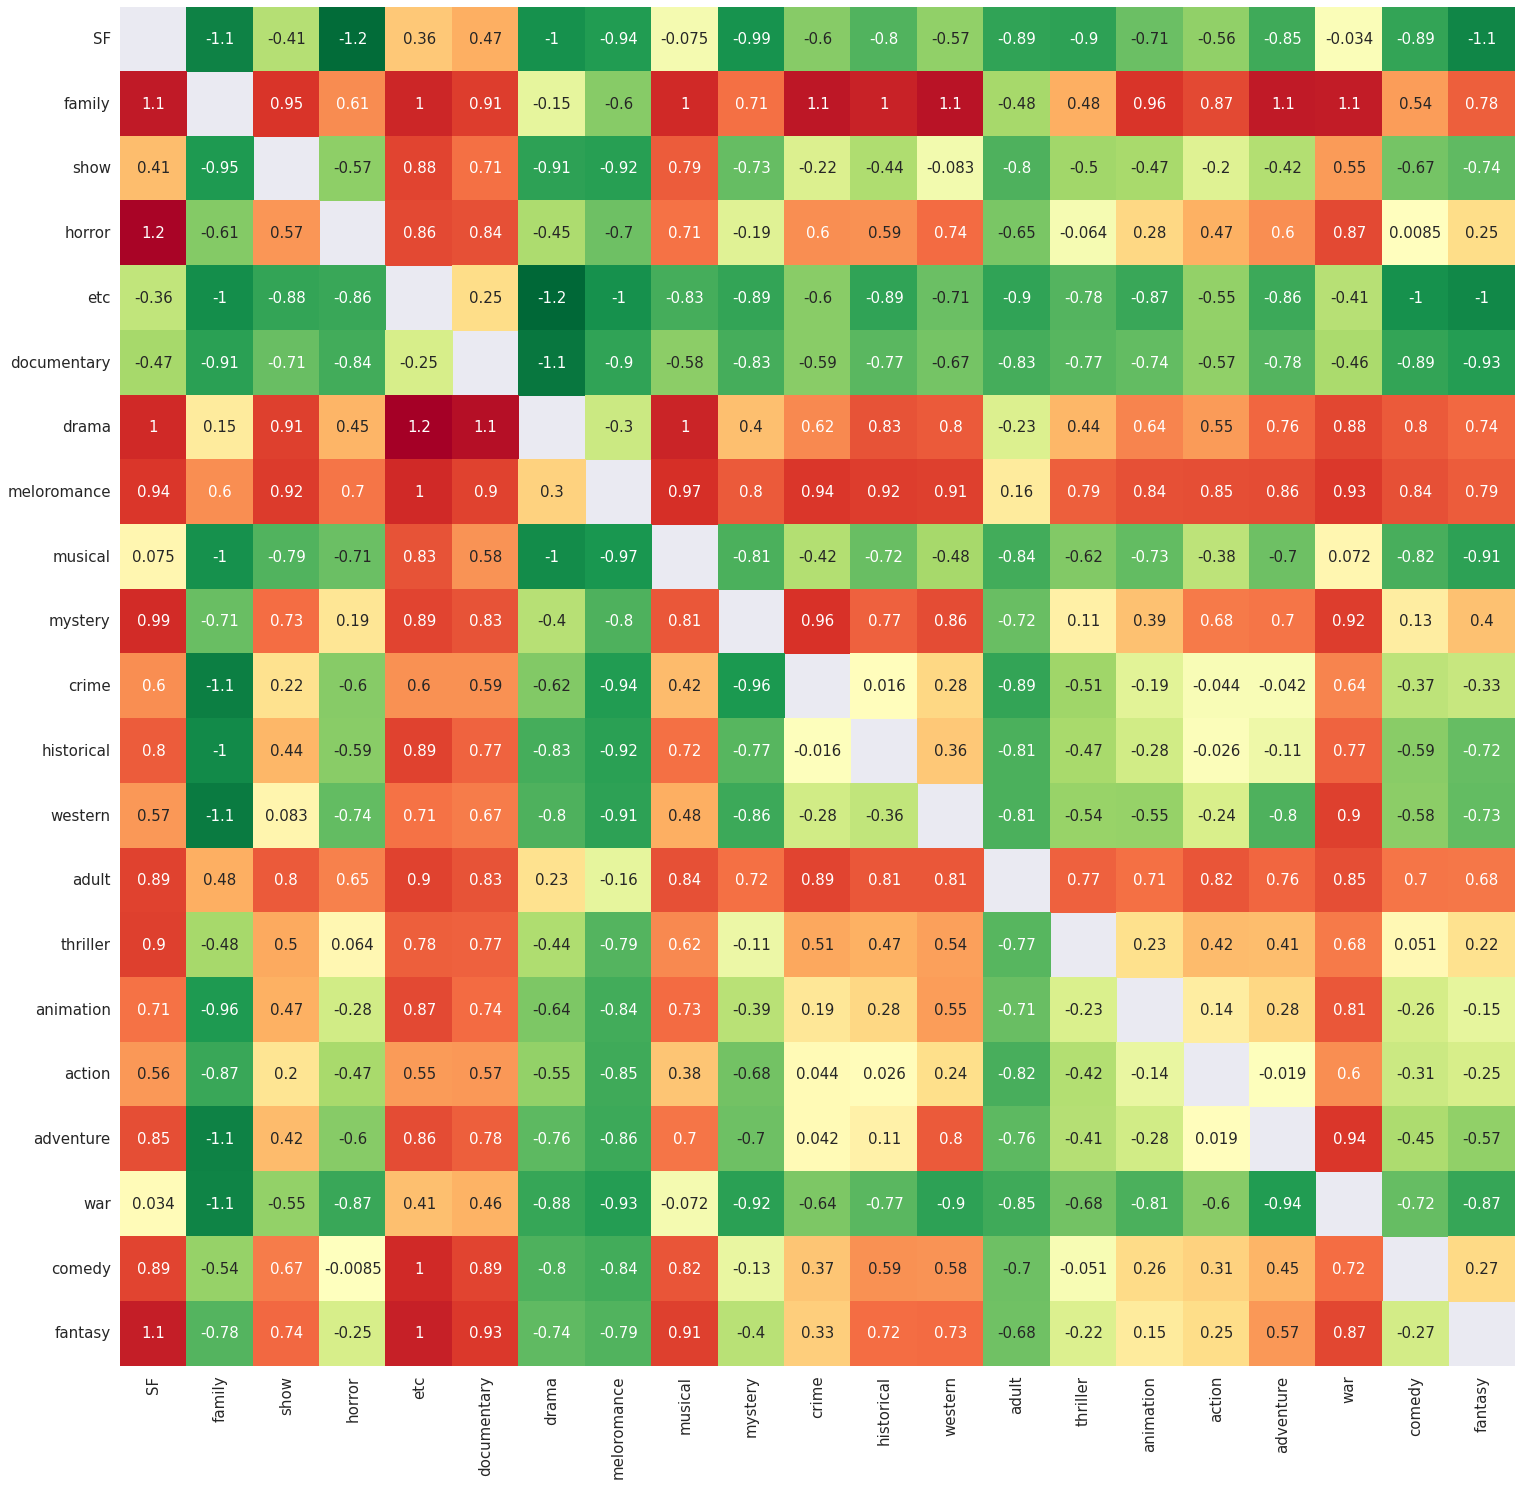

In [230]:
import matplotlib.pyplot as plt
np.random.seed(0)

# 축 라벨 이름
label = ['SF', 'family', 'show', 'horror', 'etc', 'documentary', 'drama', 'meloromance', 'musical', 'mystery', 'crime', 'historical', 'western',
         'adult', 'thriller', 'animation', 'action', 'adventure', 'war', 'comedy', 'fantasy']

# 마이너스 부호 
plt.figure(figsize=(25,25))
plt.rcParams['axes.unicode_minus'] = False
plt.tick_params(labelsize=15)

ax = sns.heatmap(matrix, xticklabels=label, yticklabels=label, annot=True,  cmap='RdYlGn_r', cbar=False ,annot_kws = {'size' : 15})
ax

높은 점수를 랜덤으로 3개 뽑아서 해석해보겠습니다. 
- SF와 공포영화 = -1.2

: 부호가 마이너스이므로, SF는 일반영화에 공포영화는 예술영화에 가깝다고 볼 수 있습니다.
- 가족영화와 범죄영화 = 1.1

: 부호가 양수이므로, 가족영화는 예술영화에 범죄영화는 일반영화에 가깝다고 볼 수 있습니다.
- 가족영화와 전쟁영화 = 1.1

:부호가 양수이므로, 가족영화는 예술영화에 전쟁영화는 일반영화에 가깝다고 볼 수 았습니다.


# 회고
- WEAT score을 구하기전에, 각 장르를 대표하는 단어들을 추출해야했기때문에 TF-IDF를 이용해서 단어들을 추출해보았다. 여기서 문제는 각 장르간 대표하는 단어들이 서로 중복이 많이 된다는 사실이다. 그래서 해당단어가 다른 장르에 있을경우 지워버리고 오로지 해당 장르에만 있는 단어만 추출해서 사용하였다. 이때 상위 15개의 단어를 추출했지만 몇개의 장르는 15개를 채우지못했다. 따라서 여기에는 두가지 문제점이 있는것같다. 첫번째는 각 장르별 대표하는 단어의 개수가 다르다는것이고, 두번째는 TF-IDF가 높은 단어들이 다 삭제됐을 수 도있다는것이다. 중복된 단어를 지워주는과정에서 각 장르를 대표하는 TF-IDF상위점수에 해당하는 단어들이 사라졌기때문이다.
- 하나의 의문점은 분명 TF-IDF는 그 계산과정자체가 특정단어가 다른 문서에는 없고 해당 문서에만 있을경우 높은 점수를 부여하는 방식이다. 그리고 그 점수를 기준으로 내림차순으로 정렬했을때, 각 장르별로 중복되는 단어가 많았다... 